# Wybór miniatury
Przygotujemy model służący do wyboru najlepszej miniatury filmu.  
**1.** Przygotowanie danych  
**2.** Ekstrakcja *głębokich* cech z obrazka  
**3.** Uczenie binarnego klasyfikatora (sieć neuronowa) do predykcji popularności  
**4.** Ekstrakcja ramek filmiku  
**5.** Przewidywanie popularności dla ramek  
**6.** Wybór ramki z najlepszym wynikiem

## Przygotowanie danych
Mamy dane w postaci
- miniatura, liczba wyświetleń, id kanału, na którym został umieszczony film  

```
video_views.txt
10154460651529281/10154460653299281_beginning.jpg 171981399280 9583
747719488702894/747720578702785_beginning.jpg 407570359384477 366356
302363550107799/301325296878291_beginning.jpg 63096571313 285264
10154179624648463/10154179630493463_beginning.jpg 8245623462 614396
10154328268796661/10154328274071661_beginning.jpg 118526656660 65448
10153952967246633/10153952977416633_beginning.jpg 59685491632 72800
1092679957488794/1068082013281922_beginning.jpg 341163402640457 3176985
```
- id kanału, liczba fanów kanału
```
channel_fans.txt
63096571313 1501689
154238749766 4300744
1407167032831912 8000048
879771572075193 1001821
363765800431935 5785453
171112259610923 19367873
228735667216 33842971
26012002239 25188369
8358247707 8328358
```

Wczytamy i przygotujemy dane

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# All data
THUMBNAIL_DIR = '/home/adamb/thumbData/Facebook224'
VIEWS_PATH = '../data/all_thumbpath_views_.txt'
CHANNEL_FANS = '../data/channel_fans.txt'
# THUMBNAIL_DIR = 'thumbnails/thumbnails'
# VIEWS_PATH = 'video_views.txt'
# CHANNEL_FANS = 'channel_fans.txt'

# Read views data
with open(VIEWS_PATH) as f:
    data = f.read().splitlines()

video_data = []
for line in data:
    path, channel_id, views = line.split()
    video_data.append([path, channel_id, views])

W liście `video_data` przechowujemy informacje o ścieżce do miniaturki, id kanału, na którym został udostępniony filmik, oraz liczba wyświetleń filmiku.

Wczytamy teraz liczbę lajków dla kanałów.

In [2]:
# Read channel fans data
with open(CHANNEL_FANS) as f:
    data = f.read().splitlines()

channel_fans = {}
for channel_data in data:
    channel_id, fans = channel_data.split()
    channel_fans[channel_id] = int(fans)

Aby wziąć pod uwagę większą popularność filmów wrzucanych przez popularne strony, znormalizujemy liczbę wyświetleń przez liczbę fanów danej strony.

Na podstawie znormalizowanej liczby wyświetleń, każdemu z filmów przypiszemy etykietę w zależności od tego, czy wartość ta jest powyżej czy poniżej mediany.

In [3]:
# Normalize data
for data in video_data:
    data[2] = float(data[2]) / channel_fans[data[1]]

# Assign_labels
normalized_views = [data[2] for data in video_data]
labels = pd.qcut(normalized_views, 2, labels=False)
imgpaths = [os.path.join(THUMBNAIL_DIR, data[0]) for data in video_data]

Zmienna `labels` przechowuje etykietę dla filmu 0 lub 1 odpowiednio dla niepopularnych i popularnych filmików.  
Wczytamy teraz obrazki z miniaturami filmów.

In [4]:
from keras.preprocessing.image import load_img, img_to_array
import os

# Load images
images = []
for path in imgpaths:
    image = load_img(path)
    image = img_to_array(image)
    images.append(image)

images = np.array(images)
labels = np.array(labels, dtype=np.int)

Using TensorFlow backend.


Wizualizacja przykładowych miniatur

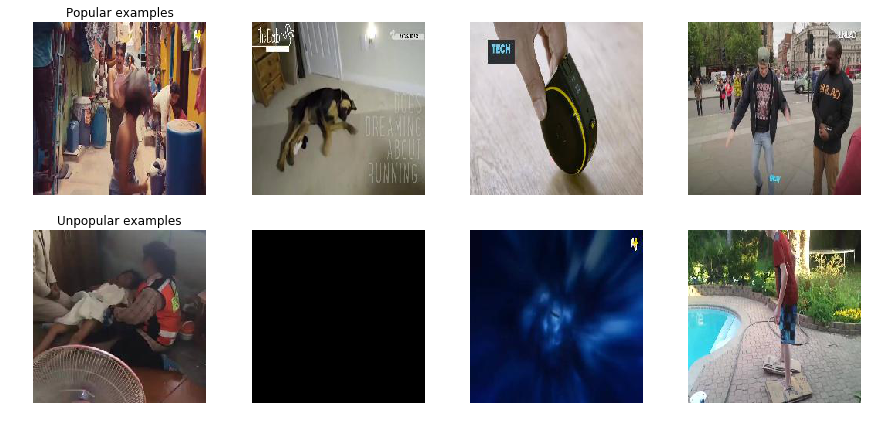

In [36]:
n_columns = 4
n_rows = 2
plt.figure(figsize=(15, 7))
popular_inds = np.random.choice(np.where(labels==1)[0], 4, replace=False)
unpopular_inds = np.random.choice(np.where(labels==0)[0], 4, replace=False)

i = 1
for ind in popular_inds:
    plt.subplot(n_rows, n_columns, i)
    plt.imshow(images[ind].astype(np.uint8))
    plt.axis('off')
    if i==1:
        plt.title('Popular examples')
    i += 1

for ind in unpopular_inds:
    plt.subplot(n_rows, n_columns, i)
    plt.imshow(images[ind].astype(np.uint8))
    plt.axis('off')
    if i==n_columns+1:
        plt.title('Unpopular examples')
    i += 1

10% danych wykorzystamy jako zbiór walidacyjny, na którym będziemy badać trening sieci.

In [6]:
split_point = int(0.1 * len(images))
val_images, val_labels = images[:split_point], labels[:split_point]
train_images, train_labels = images[split_point:], labels[split_point:]

## Ekstrakcja cech z głębokiej sieci neuronowej
Wykorzystamy model, który wytrenowany został na milionie obrazków do klasyfikacji 1000 klas (ImageNet).  

Tak wytrenowany model można wykorzystać jako **ekstraktor wektorów cech**.

<img src="images/feature_extractor.png">

Dla każdej miniatury wyciągniemy **wysokopoziomowe** wektory cech z przedostatniej warstwy głębokiej sieci neuronowej.  
Wykorzystamy architekturę ResNet50, która operuje na obrazkach wielkości *224x224* piksele
https://keras.io/applications/#resnet50

### Przygotowanie modelu

In [7]:
from keras.applications.resnet50 import ResNet50
model = ResNet50(include_top=False, weights='imagenet')

### Przygotowanie danych do sieci neuronowej

In [8]:
print(train_labels[:4])

[1 1 1 0]


In [9]:
from keras.applications.resnet50 import preprocess_input # Normalizacja danych
from keras.utils import to_categorical
train_data = preprocess_input(train_images.copy())
val_data = preprocess_input(val_images.copy())
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)

In [10]:
print(train_labels[:4])

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


In [11]:
train_features = model.predict(train_data, verbose=1)
val_features = model.predict(val_data, verbose=1)

3888/3888 [==============================] - 15s 4ms/step


In [12]:
train_features = train_features.squeeze()
val_features = val_features.squeeze()

In [13]:
print('Rozmiar obrazków: ', train_data.shape)
print('Rozmiar wektorów cech: ', train_features.shape)

Rozmiar obrazków:  (34993, 224, 224, 3)
Rozmiar wektorów cech:  (34993, 2048)


## Trenowanie modelu klasyfikacji
Każda miniaturka jest opisana przez **wektor cech** wyuczonych przez głęboką sieć neuronową oraz **etykietę: popularny/niepopularny.**  
Na podstawie tych danych wytrenujemy sieć neuronową do **klasyfikacji binarnej**.  

<img src='images/net.png'>

In [14]:
# Import
from keras.models import Sequential
from keras.layers import Dense

Aktywacja `softmax` będzie zwracała prawdopodobieństwo nalezności do klasy niepopularnej bądź popularnej

In [15]:
popularity_model = Sequential()
popularity_model.add(Dense(units=2, activation='softmax', input_shape=(2048,)))

In [16]:
popularity_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         )

In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callback = popularity_model.fit(train_features, train_labels,
                                validation_data=(val_features, val_labels),
                                callbacks=[EarlyStopping(patience=10), 
                                        ReduceLROnPlateau(patience=5, verbose=1),
                                        ModelCheckpoint('best_model.hdf5', save_best_only=True, verbose=1)], epochs=100)

Train on 34993 samples, validate on 3888 samples
Epoch 1/100
34993/34993 [==============================] - 2s 62us/step - loss: 0.7053 - acc: 0.5978 - val_loss: 0.6736 - val_acc: 0.6152
Epoch 2/100
34993/34993 [==============================] - 2s 57us/step - loss: 0.6590 - acc: 0.6290 - val_loss: 0.6714 - val_acc: 0.6304
Epoch 3/100
34993/34993 [==============================] - 2s 52us/step - loss: 0.6569 - acc: 0.6356 - val_loss: 0.6853 - val_acc: 0.6013
Epoch 4/100
34993/34993 [==============================] - 2s 51us/step - loss: 0.6488 - acc: 0.6402 - val_loss: 0.6681 - val_acc: 0.6343
Epoch 5/100
34993/34993 [==============================] - 2s 52us/step - loss: 0.6525 - acc: 0.6416 - val_loss: 0.6624 - val_acc: 0.6312
Epoch 6/100
34993/34993 [==============================] - 2s 51us/step - loss: 0.6436 - acc: 0.6443 - val_loss: 0.6847 - val_acc: 0.6281
Epoch 7/100
34993/34993 [==============================] - 2s 51us/step - loss: 0.6445 - acc: 0.6467 - val_loss: 0.7287 - v

## Ewaluacja modelu
Wczytamy ramki przykładowego filmiku i obliczymy dla nich prawdopodobieństwo popularności.

Ramka z największym wynikiem zostaje wybrana jako miniatura filmu.

In [18]:
from keras.models import load_model
popularity_model = load_model('best_model.hdf5')

In [19]:
import os
frames_dir = '../data/sample_video_frames'
video_frames_paths = sorted(os.listdir(frames_dir))

In [20]:
print(video_frames_paths)

['frame001.jpg', 'frame002.jpg', 'frame003.jpg', 'frame004.jpg', 'frame005.jpg', 'frame006.jpg', 'frame007.jpg', 'frame008.jpg', 'frame009.jpg', 'frame010.jpg', 'frame011.jpg', 'frame012.jpg', 'frame013.jpg', 'frame014.jpg', 'frame015.jpg', 'frame016.jpg', 'frame017.jpg', 'frame018.jpg', 'frame019.jpg', 'frame020.jpg', 'frame021.jpg', 'frame022.jpg', 'frame023.jpg']


In [21]:
frames_images = []
for frame in video_frames_paths:
    frame_img = load_img(os.path.join(frames_dir, frame), target_size=(224, 224))
    frame_img = img_to_array(frame_img)
    frames_images.append(frame_img)
frames_images = np.array(frames_images)

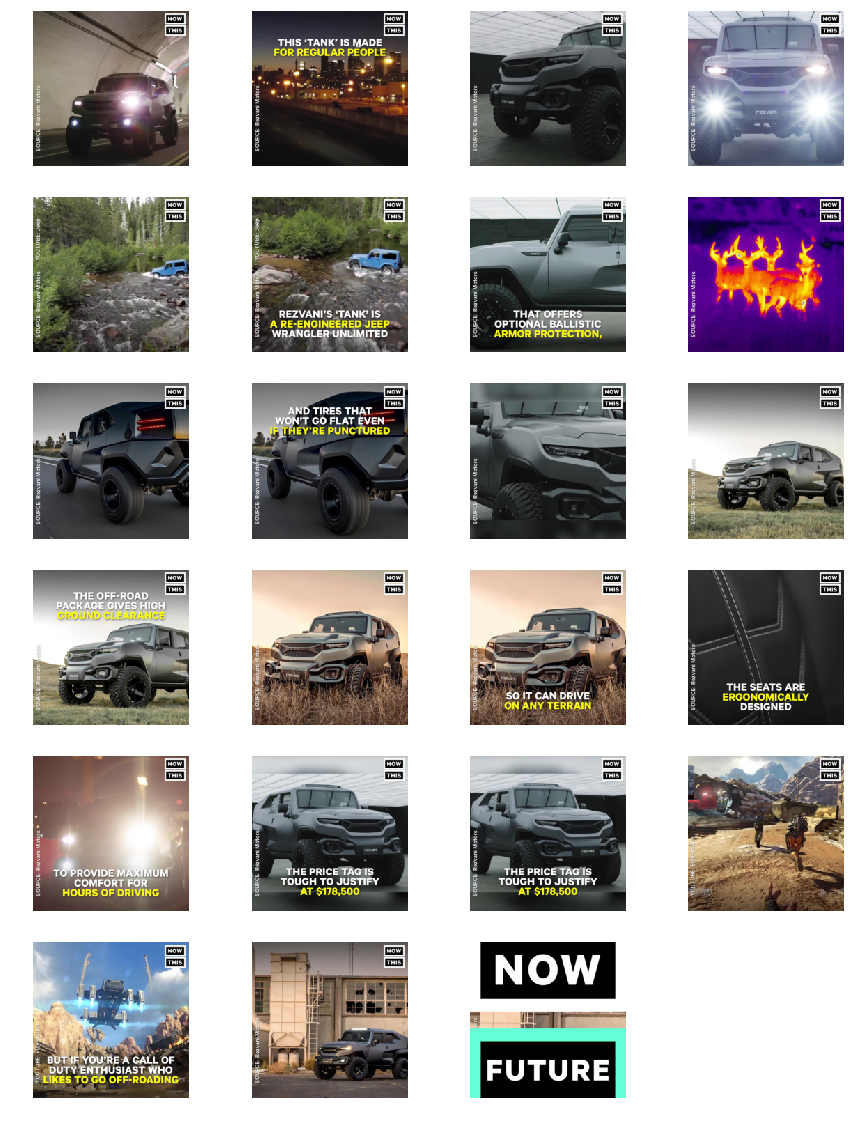

In [22]:
n_columns = 4
n_rows = int(np.ceil(float(len(frames_images)) / n_columns))
plt.figure(figsize=(15, 20))
for i, frame_image in enumerate(frames_images):
    plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(frame_image.astype(np.uint8))
    plt.axis('off')

In [23]:
def rate_frames(frames_images):
    frames_data = preprocess_input(frames_images.copy())
    frames_features = model.predict(frames_data)
    frames_features = frames_features.squeeze()
    frames_scores = popularity_model.predict(frames_features)
    frames_scores = frames_scores[:, 1]
    return frames_scores

In [24]:
frames_scores = rate_frames(frames_images)

Wyświetlimy teraz wszystkie ramki posortowane po wyniku popularności

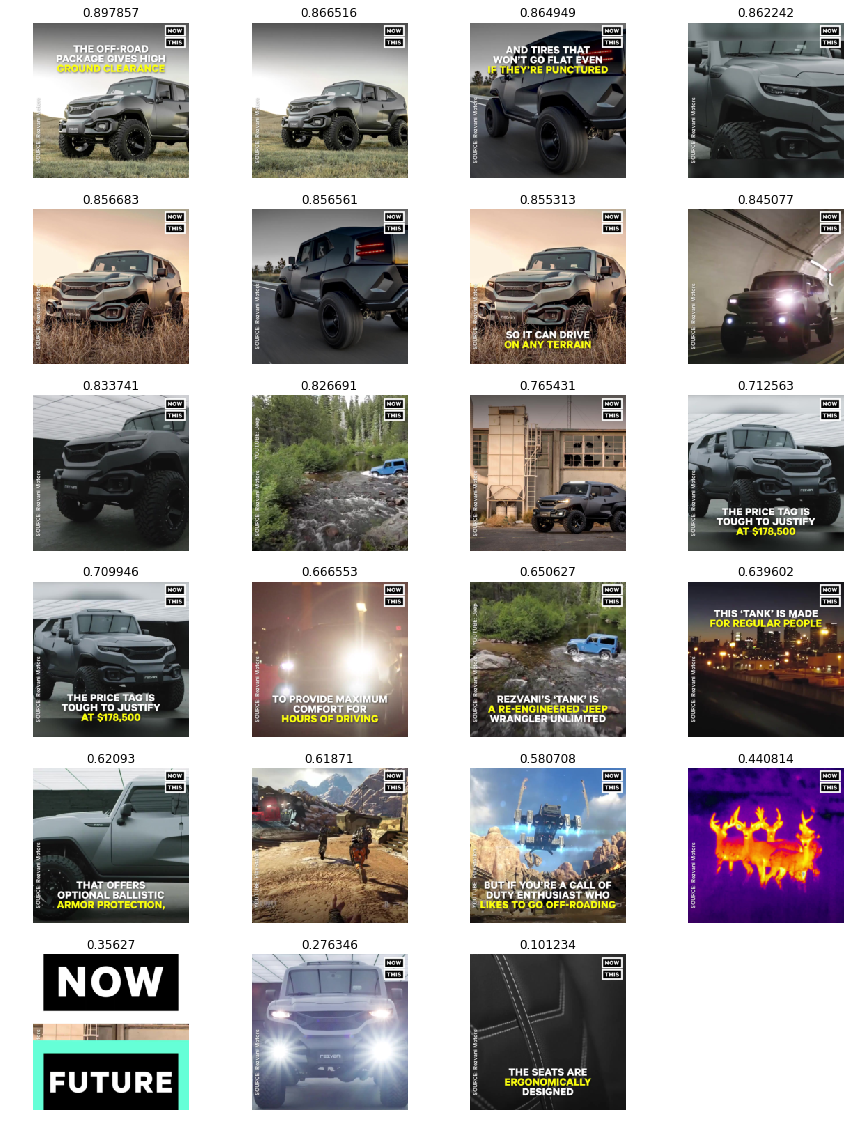

In [26]:
frames_order = np.argsort(frames_scores)[::-1]

n_columns = 4
n_rows = int(np.ceil(float(len(frames_images)) / n_columns))
plt.figure(figsize=(15, 20))
for i, frame_ind in enumerate(frames_order):
    plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(frames_images[frame_ind].astype(np.uint8))
    plt.title(frames_scores[frame_ind])
    plt.axis('off')